# iSP Seminar 3 - Part 2

## Recap
- Single qubit states
    - Bloch sphere
- Multiple qubit states
    - Engangled states

## Quantum Operations
Quantum algorithms work by applying operations on qubits. In quantum computation, the only operations allowed are linear and **unitary**, that is

$$
U^{-1}=U^\dagger,\quad U\in \mathbb{C}^{2^n\times2^n}.
$$

Since they act linearly on the state-vectors, unitary operations are **matrices**.

The fact that operations are unitaries allows to preserve the unit norm of the state-vectors.

$$
|\hat{\psi}\rangle = U|\psi\rangle \rightarrow \langle\hat{\psi}|\hat{\psi}\rangle = \langle\psi|U^{\dagger}U|\psi\rangle = \langle\psi|\psi\rangle = 1.
$$

Let's look at some of the most typical 1 and 2 qubit operations or **gates** and their matrix representation. They will recur in almost every quantum circuit.

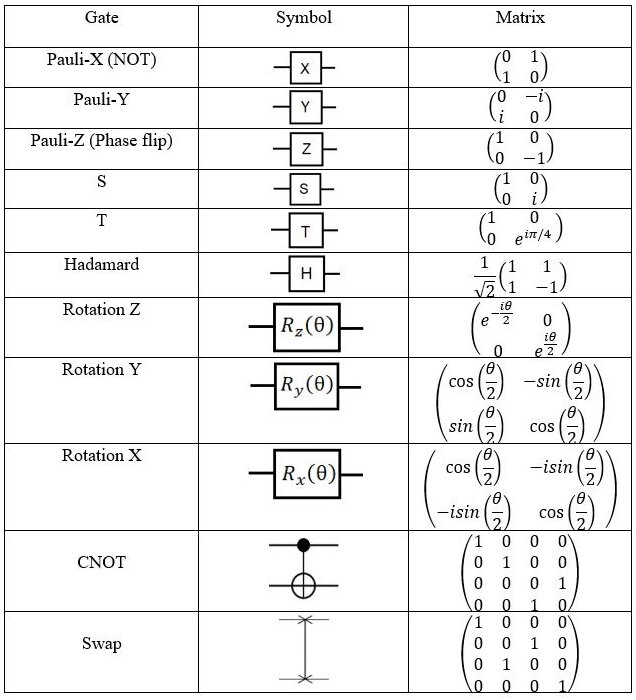

In [1]:
from IPython.display import Image

Image(filename="./figures/gate_ops_table.jpg")

## Measurements
Measurements are what allows to extract information from the quantum system. They are the only non-linear non-unitary operations allowed on qubits.

### Example: measurement in the computational basis
For the state

$$
|\psi\rangle = \frac{|0\rangle+|1\rangle}{\sqrt{2}}
$$

we want to measure the observable

$$
Z = |0\rangle\langle0| - |1\rangle\langle1| = P_0 - P_1.
$$

The probability of obtaining $|0\rangle$ is

$$
p_0 = \langle\psi|P_0|\psi\rangle = \frac{1}{2},
$$

and the probability of obtaining $|1\rangle$ is

$$
p_1 = \langle\psi|P_1|\psi\rangle = \frac{1}{2}.
$$

The state after measurements can be

$$
\frac{P_0|\psi\rangle}{\sqrt{p_0}} = |0\rangle,
$$

$$
\frac{P_1|\psi\rangle}{\sqrt{p_1}} = |1\rangle.
$$

## Quantum circuits
Quantum circuits are graphical representations of the qubits and the operations on them. Here is an example...

Matplotlib is building the font cache; this may take a moment.


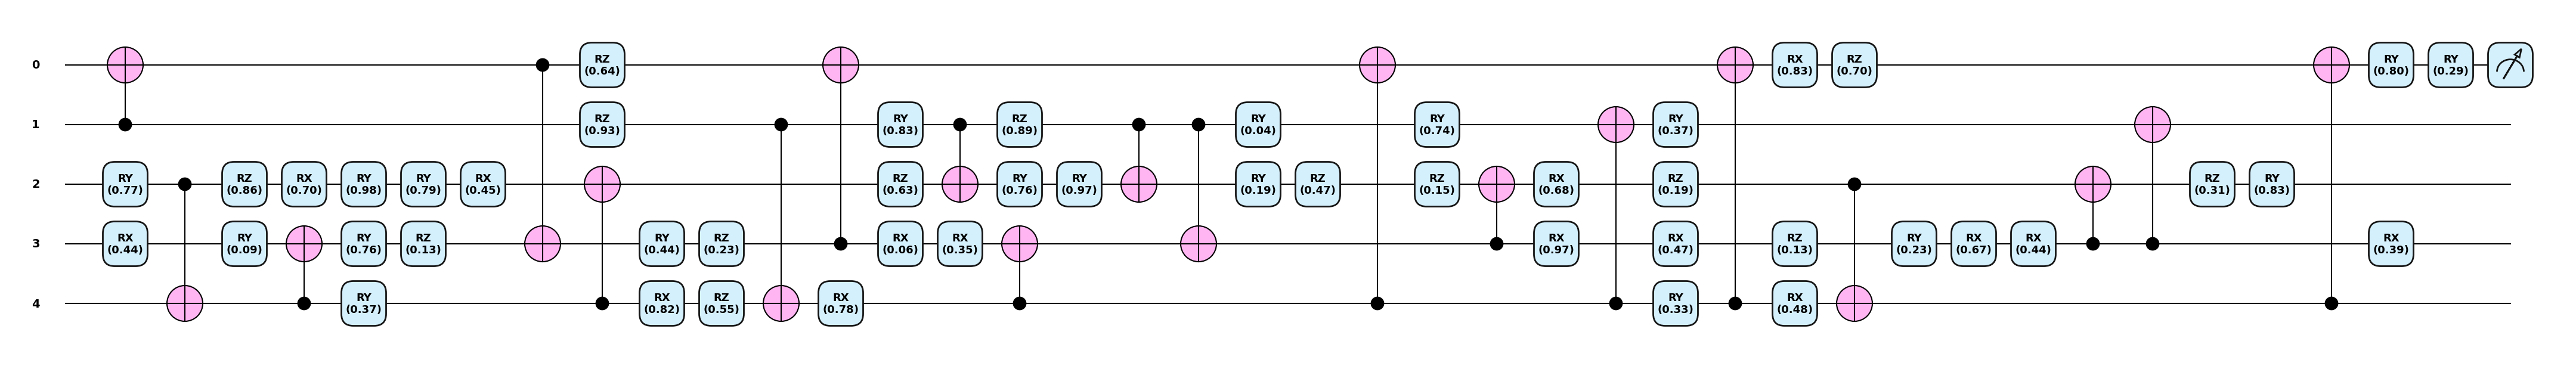

In [2]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml

rng = np.random.default_rng(seed=42)

n_qubits = 5
n_param_gates = 8
n_layers = 6

qml.device("default.qubit", wires=n_qubits)

@qml.qnode(qml.device("default.qubit", wires=n_qubits))
@partial(qml.transforms.decompose, max_expansion=1)
def rnd_circuit():
    shape = qml.RandomLayers.shape(n_layers=n_layers, n_rotations=n_param_gates)
    weights=rng.random(size=shape)
    qml.RandomLayers(weights=weights, wires=range(n_qubits))
    return qml.expval(qml.Z(0))

qml.draw_mpl(rnd_circuit, decimals = 2, style = "pennylane")()
plt.show()

Quantum circuits show how an algorithm is implemented with a given alphabet of operations, e.g. [those in the previous section](#quantum-operations). Note that they are not the lowest level implementation of the algorithm and that they generally need to be compiled to the quantum hardware, since

1. The circuit's alphabet might be different than the available operations on hardware.
2. The qubit connectivity of the hardware might be limited and we need to re-route some operation.

Note also how some gates accept parameters. If these parameters are left free, the circuits can learn (up to a certain extent) specific tasks.

Optimization of parametrized quantum circuits is the core idea of Variational Quantum Algorithms (VQAs). At iteration $t$:

$$
\begin{align*}
    f(x) = \langle\psi_\theta|O(x)|\psi_\theta\rangle\qquad &(\text{quantum}),\\
    \theta^{t+1} = \theta^{t} - \eta\nabla_{\theta^t}\qquad &(\text{classical}).
\end{align*}
$$

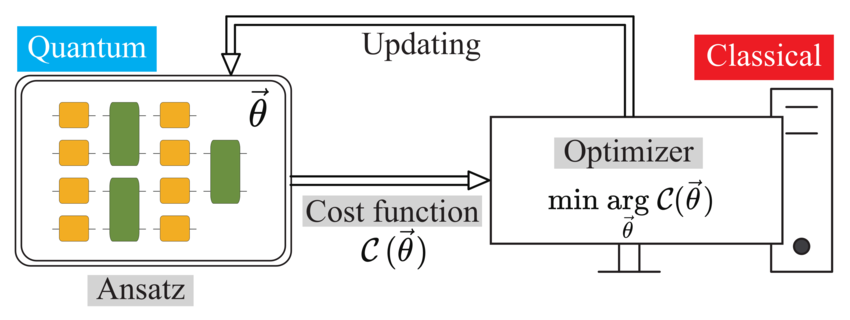

In [3]:
from IPython.display import Image

Image(filename="./figures/vqa_scheme.png")

## Quantum Circuit Born Machine
We saw that quantum states implicitely define **probability distributions** over bitstrings ($|00\dots0\rangle$, $|00\dots1\rangle$, ..., $|11\dots1\rangle$). When measured in the computational basis, the outcome will be one of the $2^n$ possible bitstrings,

$$
x\sim p(x)=|\langle x|\psi\rangle|^2.
$$

By parametrizing the quantum circuit that prepares $|\psi\rangle$, the probability function will be parametrized itself,

$$
p_\theta(x)=|\langle x|\psi_\theta\rangle|^2.
$$

If we have access to some samples from a target distribution $\pi$, then we can train $p_\theta$ to learn $\pi$. This is the principle of Quantum Circuit Born Machines (QCBMs).

### Randomly Initialized Circuits
Let's first build some quantum circuits with parametrized gates. Let's see what happens as we change the parameter values, by running the following cell several times.

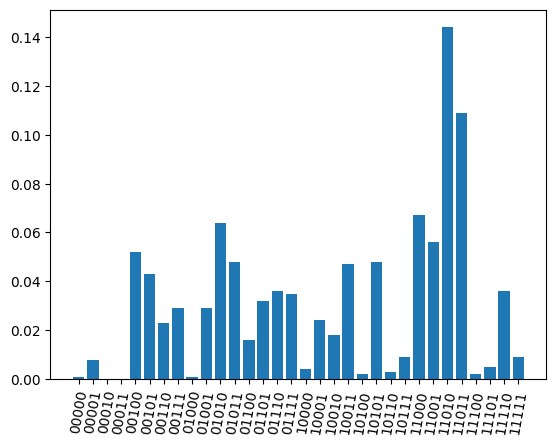

In [4]:
n_qubits = 5
n_layers = 3

# we define the number of times that we sample a circuit (shots).
n_shots = 1_000

# a PennyLane device is either a real device or a simulator.
dev = qml.device("default.qubit", wires=n_qubits)

wshape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
weights = rng.uniform(low=-np.pi, high=np.pi, size=wshape)

# The qnode is the quantum model.
@qml.set_shots(n_shots)
@qml.qnode(dev)
def circuit_qcbm(weights):
    qml.StronglyEntanglingLayers(weights=weights, ranges=[1] * n_layers, wires=range(n_qubits))
    return qml.counts(all_outcomes=True)

# Get the samples and plot the histogram
outcomes = circuit_qcbm(weights)
bitstrings = outcomes.keys()
relative_counts = [v / n_shots for v in outcomes.values()]

plt.bar(
    outcomes.keys(),
    relative_counts
)

plt.xticks(range(2 ** n_qubits), bitstrings, rotation=80)

plt.show()

As we can see, different parameter values provide us with different distibutions.

Now we need a training routine to bring our QCBM distribution close to the distribution of the data.

### Bars and Stripes images
We take a toy example that will require a few qubits (9) to show the QCBM learning. It consists of images of bars and stripes corresponding to bitstrings, which allows easy encoding in the quantum circuit.


Sample bitstring: 010010010


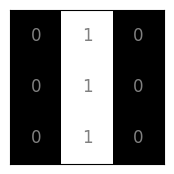

In [5]:
from utils import BarsAndStripes

ds = BarsAndStripes(n=3)

ds.plot_sample(sample_id=2)

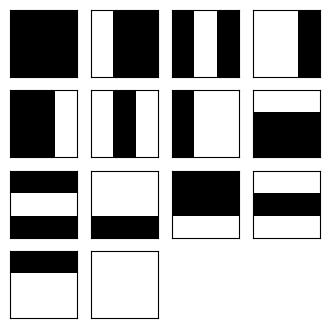

In [6]:
ds.plot_dataset()

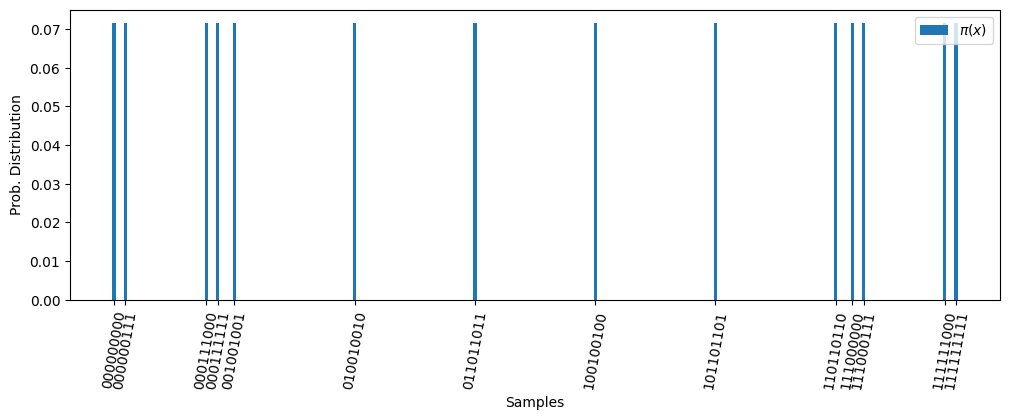

In [7]:
ds.plot_data_dist()

**Task**: we want to train the QCBM. If we are successful, after training, it should generate only bars and stripes images.

### Maximum Mean Discrepancy and Kernels
The QCBM does not give us an explicit probability distribution. This is because quantum mechanics does not allow to observe the full state vector, but only to draw samples from it.

In other words **we do not have access to the likelihood** $p(x|\theta)$, but only to **samples** of it,

$$
x\sim p(x|\theta)=|\langle x|\psi(\theta)\rangle|^2.
$$

Therefore, we cannot use the KL-divergence,

$$
D(p||\pi)=\sum_{x\sim \mathcal{X}} p(x|\theta)\log\bigg(\frac{p(x|\theta)}{\pi(x)}\bigg).
$$

For training the QCBM, but we need to use a loss based on samples. An example is the **Maximum Mean Discrepancy** (MMD),

$$
\begin{align*}
\mathcal{L}(\theta)&=\bigg|\bigg| \sum_{x\sim \mathcal{X}}p(x|\theta)\phi(x)-\sum_{x\sim \mathcal{X}}\pi(x)\phi(x) \bigg|\bigg| ^2\\
&=\mathbb{E}_{x,y\sim p_{\theta}}[K(x,y)] - 2\mathbb{E}_{x\sim p_{\theta},\,y\sim\pi}[K(x,y)] + \mathbb{E}_{x,y\sim \pi}[K(x,y)].
\end{align*}
$$

The second equality is what allows the calculation of the MMD via the _kernel trick_. Here we use a mixture of a Gaussian kernels with different scales,

$$
K(x,y)=\frac{1}{N_s}\sum_{i=1}^{N_s}\exp\bigg(\frac{|x-y|^2}{2\sigma_i^2}\bigg).
$$

We first build a parametrized circuit that can sample bitstrings and then a class that calculates MMD and its gradient.

In [19]:
import jax
import jax.numpy as jnp

# jax.config.update("jax_enable_x64", True)

n_shots = 200
n_qubits = ds.size
n_layers = 6

rng_key = jax.random.key(42)

dev = qml.device("default.qubit", wires=n_qubits)

wshape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
weights_init = jax.random.uniform(key=rng_key, shape=wshape)

@jax.jit
@qml.set_shots(n_shots)
@qml.qnode(dev)
def pqc(weights):
    qml.StronglyEntanglingLayers(weights=weights, ranges=[1] * n_layers, wires=range(n_qubits))
    return qml.sample()

In [ ]:
import optax

from utils import MMD_Gauss_Mix

scales = jnp.array([0.25, 0.5, 1])

mmd = MMD_Gauss_Mix(scales=scales, circuit=pqc, target_dist=ds.sample_integer, n_shots=n_shots)

opt = optax.adam(learning_rate=0.1)

In [24]:
@jax.jit
def update_step(i, args):
    weights, opt_state = args

    loss, grad = mmd.compute_loss(weights), mmd.compute_gradient(weights)

    updates, opt_state = opt.update(grad, opt_state)
    weights = optax.apply_updates(weights, updates)

    def print_fn():
        jax.debug.print("Step: {i},  Loss: {loss_val}", i=i, loss_val=loss)

    # if the step is multiple of 10, print the loss, else do nothing.
    jax.lax.cond(jnp.mod(i, 10) == 0, print_fn, lambda: None)

    return (weights, opt_state)

@jax.jit
def optimize(weights):
    n_iterations = 100
    opt_state = opt.init(weights)

    args = (weights, opt_state)
    (weights, opt_state) = jax.lax.fori_loop(0, n_iterations, update_step, args)

    return weights


In [25]:
optimize(weights_init)

Step: 0,  Loss: 1.0507842302322388
Step: 10,  Loss: 1.0512611865997314
Step: 20,  Loss: 1.0707875490188599
Step: 30,  Loss: 1.0539734363555908
Step: 40,  Loss: 1.0533132553100586
Step: 50,  Loss: 1.0712997913360596
Step: 60,  Loss: 1.0407865047454834
Step: 70,  Loss: 1.0549625158309937
Step: 80,  Loss: 1.0502345561981201
Step: 90,  Loss: 1.064373254776001


Array([[[0.48870957, 0.6797972 , 0.6162715 ],
        [0.5610161 , 0.4506446 , 0.58586586],
        [0.07480943, 0.7751334 , 0.69895923],
        [0.8186337 , 0.3503052 , 0.87282   ],
        [0.9258814 , 0.86013067, 0.47755408],
        [0.8184818 , 0.7113545 , 0.5866972 ],
        [0.07373738, 0.7776222 , 0.40456557],
        [0.11912322, 0.02625561, 0.63917875],
        [0.40473115, 0.8878412 , 0.08147442]],

       [[0.29640484, 0.6066797 , 0.9382349 ],
        [0.7560079 , 0.45863354, 0.3077258 ],
        [0.7508552 , 0.54413235, 0.36401415],
        [0.6754104 , 0.590114  , 0.28874826],
        [0.18861508, 0.41546822, 0.6209631 ],
        [0.4257444 , 0.5373006 , 0.6457536 ],
        [0.14520729, 0.6724436 , 0.88701296],
        [0.66781366, 0.24078846, 0.5700073 ],
        [0.42124724, 0.41367304, 0.90064776]],

       [[0.64630044, 0.42933118, 0.40524614],
        [0.34097075, 0.6432344 , 0.8825629 ],
        [0.1495204 , 0.21350837, 0.85509944],
        [0.35862052, 0.4780222